In [57]:
import pickle
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from data_augmentation import crop
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# Attention layer
class Attention(nn.Module):
    def __init__(self, feature_dim, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        weight = torch.zeros(feature_dim, 1).to(device)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
    def forward(self, x):
        # x structure: (batch size, step dim, feature dim)
        feature_dim = self.feature_dim 
        step_dim = x.shape[1] 
        # eij structrue: (batch size, step dim)
        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)
        self.a = a # record attention weight for each time step
        weighted_input = x * torch.unsqueeze(a, -1)
        
        return torch.sum(weighted_input, 1)

# Attention based bidirectional recurrent neural network (LSTM Cell)
class AttenBiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AttenBiRNN, self).__init__()
        self.num_layers = num_layers
        self.lstm_layers = nn.ModuleList(
        [nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)])   
        self.attention_layers = nn.ModuleList(
            [Attention(2*hidden_size)])
        for i in range(1, num_layers):
            self.lstm_layers.append(nn.LSTM(2*hidden_size, hidden_size, batch_first=True, bidirectional=True))   
            self.attention_layers.append(Attention(2*hidden_size))
        self.attention_layers.append(Attention(2*hidden_size))
        self.fc = nn.Sequential(
                    nn.Linear(2*hidden_size, 128),
                    nn.ReLU(True),
                    nn.Linear(128, num_classes))

    def forward(self, x):
        a = []
        h = x
        for i in range(self.num_layers):
            # h: tensor of shape (batch_size, seq_length, hidden_size*2)
            h, _ = self.lstm_layers[i](h)
            a_n = self.attention_layers[i](h)
            a.append(a_n)
        a = torch.cat([a_n.unsqueeze(1) for a_n in a], dim=1)
        h = self.attention_layers[-1](a)
        out = self.fc(h)
        return out

In [59]:
def variance_and_bias_analysis(train_loss, valid_loss, save_name = 'loss_plot.png'):
    fontsize = 20
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
    # Find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    plt.xlabel('epochs', fontsize=fontsize)
    plt.ylabel('loss', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # plt.ylim(0, 0.8) # Consistent scale
    plt.xlim(0, len(train_loss)+1) # Consistent scale
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=fontsize)
    fig.savefig(save_name, bbox_inches='tight')


def plot_confusion_matrix(y_true, y_pred, labels_name, save_name='confusion_matrix.png'):
    fontsize = 20
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, annot=True, cmap='Blues',
                    xticklabels=labels_name, yticklabels=labels_name, annot_kws={"size": fontsize})
    ax.set_ylabel('Ground Truth', fontsize=fontsize)
    ax.set_xlabel('Predictions', fontsize=fontsize)
    plt.tight_layout()
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.savefig(save_name)

In [60]:
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [61]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 0  # this parameter will be renewed in 'dataloader' function
input_size = 36  # including 6 channels of 6 IMU sensors, totally 36 channels
hidden_size = 256  # parameters for LSTM (Long Short Term Memory)
# num_layers = 2  # the depth of Deep-RNNs
num_classes = 4 # number of classes
batch_size = 48 # training batch size
num_epochs = 60 # epoch number
lr = 5e-4 # learning rate
patience = 20 # patience for early stopping

# Test parameters
RANDOM_SEED_NUM = 0 # random seed
TEST_NUM = 1 # test times
LABELS = ['right_standing', 'wrong_standing', 'right_turning', 'wrong_turning'] # action labels
DATASET_NAME = 'dataset.pkl' # the file name of dataset


def data_load():

    dataset_name0 = 'lin'
    dataset_name1 = 'zhong'
    actions = LABELS
    pkl_file = open(DATASET_NAME, 'rb')
    dataset = pickle.load(pkl_file)
    pkl_file.close()
    dataset0 = dataset[dataset_name0]
    dataset1 = dataset[dataset_name1]

    # get longest length among different actions
    max_t = max(dataset0['length_range'][1], dataset1['length_range'][1])
    global sequence_length
    sequence_length = max_t  # the longest length of sample

    # divide the dataset into train set, dev set and test set
    x_train, y_train, x_dev, y_dev, x_test, y_test = [], [], [], [], [], []
    for label, action in enumerate(actions):

        # lin
        labels = [label] * len(dataset0[action])
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(dataset0[action], labels, test_size=0.4, random_state=RANDOM_SEED_NUM)
        x_train += temp_train_x
        y_train += temp_train_y
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(temp_test_x, temp_test_y, test_size=0.5, random_state=RANDOM_SEED_NUM)
        x_dev += temp_train_x
        y_dev += temp_train_y
        x_test += temp_test_x
        y_test +=temp_test_y

        # zhong
        labels = [label] * len(dataset1[action])
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(dataset1[action], labels, test_size=0.4, random_state=RANDOM_SEED_NUM)
        x_train += temp_train_x
        y_train += temp_train_y
        temp_train_x, temp_test_x, temp_train_y, temp_test_y = \
            train_test_split(temp_test_x, temp_test_y, test_size=0.5, random_state=RANDOM_SEED_NUM)
        x_dev += temp_train_x
        y_dev += temp_train_y
        x_test += temp_test_x
        y_test += temp_test_y

    # data augmentation
    x_train, y_train = crop(x_train, y_train)

    # pad the data samples
    for i in range(len(x_train)):
        x_train[i] = \
            np.pad(x_train[i][:, 1:], ((0, max_t - x_train[i].shape[0]), (0, 0)), 'constant', constant_values=0)
    for i in range(len(x_dev)):
        x_dev[i] = \
            np.pad(x_dev[i][:, 1:], ((0, max_t - x_dev[i].shape[0]), (0, 0)), 'constant', constant_values=0)
    for i in range(len(x_test)):
        x_test[i] = \
            np.pad(x_test[i][:, 1:], ((0, max_t - x_test[i].shape[0]), (0, 0)), 'constant', constant_values=0)

    # shuffle
    x_train, y_train = shuffle(x_train, y_train, random_state=RANDOM_SEED_NUM+1)
    x_dev, y_dev = shuffle(x_dev, y_dev, random_state=RANDOM_SEED_NUM+2)
    x_test, y_test = shuffle(x_test, y_test, random_state=RANDOM_SEED_NUM+3)

    # change dataset's data format
    x_train, y_train = \
        torch.from_numpy(np.array(x_train)).type(torch.FloatTensor),\
        torch.from_numpy(np.array(y_train)).type(torch.LongTensor)
    x_dev, y_dev = \
        torch.from_numpy(np.array(x_dev)).type(torch.FloatTensor),\
        torch.from_numpy(np.array(y_dev)).type(torch.LongTensor)
    x_test, y_test = \
        torch.from_numpy(np.array(x_test)).type(torch.FloatTensor),\
        torch.from_numpy(np.array(y_test)).type(torch.LongTensor)

    return x_train, y_train, x_dev, y_dev, x_test, y_test


def training_model(num, num_layers):
    # torch.manual_seed(RANDOM_SEED_NUM)
    global lr
    global patience
    # Load the dataset
    X_training, Y_training, X_valid, Y_valid, X_test, Y_test = data_load()
    # Record losses, accuracies and labels for drawing analysis figures
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    # Early stopping mechanism
    early_stopping = EarlyStopping(patience=patience, verbose=False)
        
    # Create the model
    model = AttenBiRNN(input_size, hidden_size, num_layers, num_classes).to(device)
    # Multiple GPU setting
#     if torch.cuda.device_count()>1:
#         model = nn.DataParallel(model)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss() # Cross Entropy Loss funtion
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimzer

    # Create Pytorch's dataloader for training, valid and test dataset
    train_dataset = TensorDataset(X_training, Y_training)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataset = TensorDataset(X_valid, Y_valid)
    valid_loader = DataLoader(valid_dataset)
    test_dataset = TensorDataset(X_test, Y_test)
    test_loader = DataLoader(test_dataset)

    # Start training the model
    for epoch in range(num_epochs):
        # Adjust learning rate according to epoch
        if epoch >= 15:
            lr = 1e-4
        if epoch >= 30:
            lr = 5e-5
        if epoch >= 45:
            lr = 1e-5
        adjust_learning_rate(optimizer, lr)
        
        '''Training'''
        model.train()  # prep model for tarining
        for batch, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.reshape(-1).to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Record loss
            train_losses.append(loss.item())
        
        '''Validation'''
        model.eval() # prep model for validation
        for (inputs, labels) in valid_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.reshape(-1).to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # record validation loss
            valid_losses.append(loss.item())
        
        # Calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        # Clear lists to track losses for next epoch
        train_losses = []
        valid_losses = []
        
        # Print information
        print('Trial [{}], Epoch [{}/{}], train loss: {:.5f}, valid loss: {:.5f}'
              .format(num+1, epoch + 1, num_epochs, train_loss, valid_loss))       
        # Early stop judgment
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # Save the graph of variance and bias analysis
    save_name = 'trials' + str(num+1) + '_loss' + '.png'
    variance_and_bias_analysis(avg_train_losses, avg_valid_losses, save_name)
    # Load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return avg_valid_losses[-1], model, test_loader


def test_model(num, model, test_loader):
    # Test the model on test set
    model.eval()
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    for (inputs, labels) in test_loader:
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.reshape(-1).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        y_true.append(labels.item())
        y_pred.append(predicted.item())
    
    # accuracy = (correct/total)*100
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print('Accuracy: {:.4f}%, Recall: {:.4f}%, Precision: {:.4f}%, F1: {:.4f}%'.format(accuracy*100, recall*100, precision*100, f1*100))
    save_name = 'trial'+str(num+1)+'_confusion_matrix' + '.png'
    labels_name = ['RS', 'WS', 'RT', 'WT']
    plot_confusion_matrix(y_true, y_pred, labels_name, save_name)
    
    return accuracy, recall, precision, f1


def main(num, num_layers):
    accuracy_list, recall_list, precision_list, f1_list = [], [], [], []
    models = []
    for i in range(num):
        loss, model, test_loader = training_model(i, num_layers)
        models.append(model)
        accuracy, recall, precision, f1 = test_model(i, model, test_loader)
        accuracy_list.append(accuracy)
        recall_list.append(recall)
        precision_list.append(precision)
        f1_list.append(f1)
    print('{} times average accuracy: {:.4f}%, recall: {:.4f}%, precision:{:.4f}%, f1: {:.4f}%.'
          .format(num, np.mean(accuracy_list)*100, np.mean(recall_list)*100, np.mean(precision_list)*100, np.mean(f1_list)*100))
    index = f1_list.index(max(f1_list))
    best_model = models[index]
    # Save the modal checkpoint
    torch.save(best_model.state_dict(), 'DeepNAR_model.ckpt')
    
    return np.mean(accuracy_list)
    

Trial [1], Epoch [1/60], train loss: 1.28893, valid loss: 1.12700
Trial [1], Epoch [2/60], train loss: 0.99210, valid loss: 0.80978
Trial [1], Epoch [3/60], train loss: 0.67744, valid loss: 0.51736
Trial [1], Epoch [4/60], train loss: 0.45509, valid loss: 0.39091
Trial [1], Epoch [5/60], train loss: 0.32891, valid loss: 0.32958
Trial [1], Epoch [6/60], train loss: 0.26989, valid loss: 0.27368
Trial [1], Epoch [7/60], train loss: 0.19984, valid loss: 0.20520
Trial [1], Epoch [8/60], train loss: 0.13385, valid loss: 0.14749
Trial [1], Epoch [9/60], train loss: 0.07710, valid loss: 0.10736
Trial [1], Epoch [10/60], train loss: 0.04054, valid loss: 0.08990
Trial [1], Epoch [11/60], train loss: 0.02117, valid loss: 0.07800
Trial [1], Epoch [12/60], train loss: 0.01161, valid loss: 0.07792
Trial [1], Epoch [13/60], train loss: 0.00696, valid loss: 0.08517
EarlyStopping counter: 1 out of 20
Trial [1], Epoch [14/60], train loss: 0.00471, valid loss: 0.09445
EarlyStopping counter: 2 out of 20
T

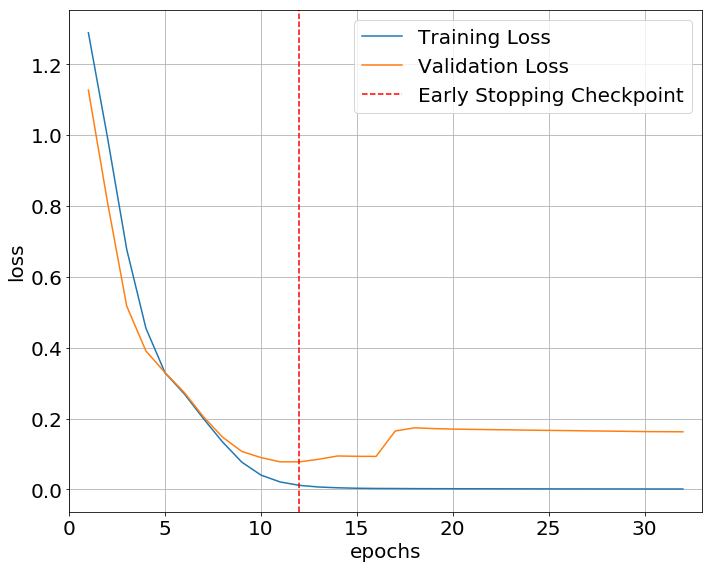

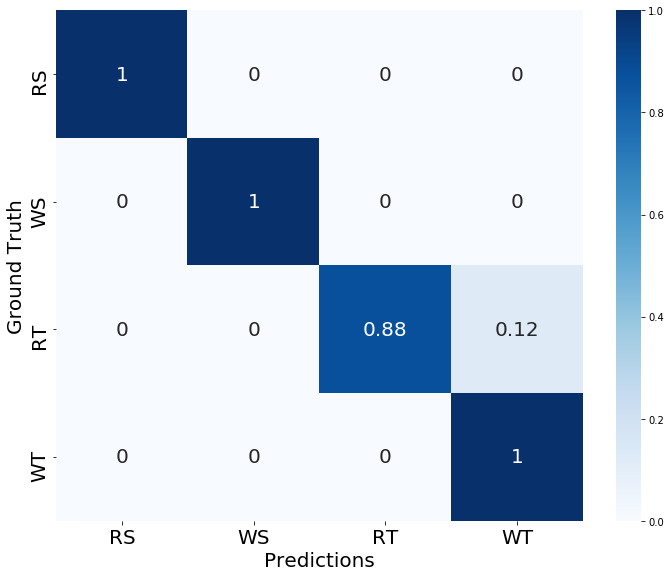

In [62]:
accuracy_list = []
best_model = None
for i in range(2,3):
    start = datetime.datetime.now()
    ac = main(num=TEST_NUM, num_layers=i)
    accuracy_list.append(ac)
    end = datetime.datetime.now()
    print('Cost time: ', end-start)
for i in range(len(accuracy_list)):
    print('{} attention layers {} times average accuray: {:.4f}%'
          .format(i+1, TEST_NUM, accuracy_list[i]*100))

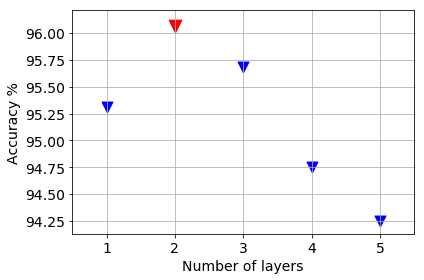

In [63]:
fontsize = 14
x = [95.3125, 96.0625, 95.6875, 94.7500, 94.2500]
plt.scatter([i+1 for i in range(len(x))], x, s=120, marker='v', c='blue')
plt.scatter([2], [96.0625], s=160, marker='v', c='red')
plt.xlabel('Number of layers', fontsize = fontsize)
plt.ylabel('Accuracy %', fontsize = fontsize)
plt.xticks([i for i in range(0,6)], fontsize=fontsize)
plt.xlim(0.5,5.5)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.grid()
plt.savefig('layers_analysis.png', bbox_inches='tight')

In [82]:
model = AttenBiRNN(input_size, hidden_size, num_layers=2, num_classes=num_classes).to(device)
model.load_state_dict(torch.load('DeepNAR_model.ckpt'))
X_training, Y_training, X_valid, Y_valid, X_test, Y_test = data_load()
train_dataset = TensorDataset(X_training, Y_training)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid, Y_valid)
valid_loader = DataLoader(valid_dataset)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset)
for (inputs, labels) in test_loader:
    inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.reshape(-1).to(device)
    outputs = model(inputs)

[0.11931836 0.88068163]


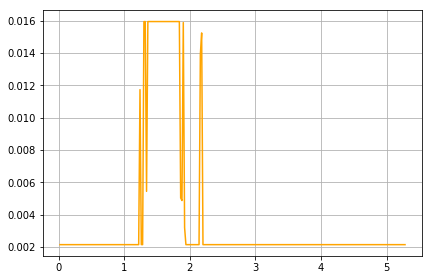

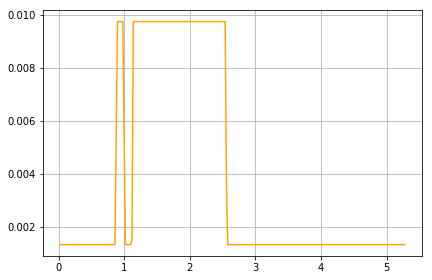

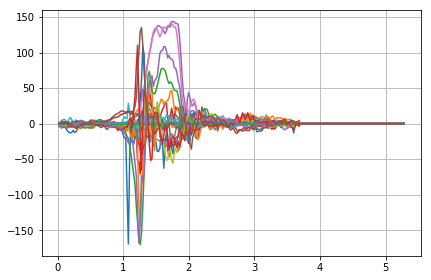

In [98]:
a1 = model.attention_layers[0].a.detach().cpu().numpy()[0]
a2 = model.attention_layers[1].a.detach().cpu().numpy()[0]
a3 = model.attention_layers[2].a.detach().cpu().numpy()[0]
plt.figure()
plt.grid()
plt.tight_layout()
plt.plot([0.02*i for i in range(1, len(a1)+1)], a1, color='Orange')
plt.figure()
plt.grid()
plt.tight_layout()
plt.plot([0.02*i for i in range(1, len(a2)+1)], a2, color='Orange')
print(a3)
plt.figure()
plt.grid()
plt.tight_layout()
x = inputs.cpu().numpy().squeeze()
plt.plot([0.02*i for i in range(1, len(x)+1)], x)